In [2]:
import numpy as np 
import keras  
from keras.datasets import mnist 
from keras.models import Model 
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten 
from keras import backend as k 

Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
#some preprocessing
img_rows, img_cols=28, 28
  
if k.image_data_format() == 'channels_first': 
   x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) 
   x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols) 
   inpx = (1, img_rows, img_cols) 
  
else: 
   x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1) 
   x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1) 
   inpx = (img_rows, img_cols, 1) 
  
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train /= 255
x_test /= 255

In [6]:
y_train = keras.utils.to_categorical(y_train) 
y_test = keras.utils.to_categorical(y_test) 

In [7]:
#my_model
inpx = Input(shape=inpx) 
layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inpx) 
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1) 
layer3 = MaxPooling2D(pool_size=(3, 3))(layer2) 
layer4 = Dropout(0.5)(layer3) 
layer5 = Flatten()(layer4) 
layer6 = Dense(250, activation='sigmoid')(layer5) 
layer7 = Dense(10, activation='softmax')(layer6) 

In [8]:
model = Model([inpx], layer7) 
model.compile(optimizer=keras.optimizers.Adadelta(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy']) 
  
model.fit(x_train, y_train, epochs=12, batch_size=500) 

Epoch 1/12
60000/60000 [==============================] - 11s 182us/step - loss: 0.7402 - accuracy: 0.7712
Epoch 2/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.2236 - accuracy: 0.9364
Epoch 3/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.1326 - accuracy: 0.9625
Epoch 4/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0956 - accuracy: 0.9724
Epoch 5/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0766 - accuracy: 0.9774
Epoch 6/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0656 - accuracy: 0.9805
Epoch 7/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0572 - accuracy: 0.9828
Epoch 8/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0494 - accuracy: 0.9852
Epoch 9/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0460 - accuracy: 0.9869
Epoch 10/12
60000/60000 [============================

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1024

In [10]:
# model accuracy and loss
score = model.evaluate(x_test, y_test, verbose=0) 
print('loss=', score[0]) 
print('accuracy=', score[1]) 

loss= 0.029458514422969893
accuracy= 0.9904000163078308


In [11]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [15]:
model.save("/content/gdrive/My Drive/GradCam/my_model.h5")

5


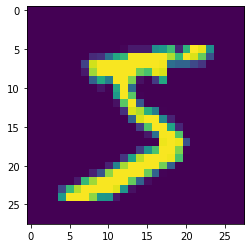

In [121]:
#loading an image for inspection
import matplotlib.pyplot as plt

(x_imp, y_imp), (x_test_inp, y_test_inp) = mnist.load_data()
print(y_imp[0]) 
plt.imshow(x_imp[0])

In [172]:
#getting the class
predict = model.predict(np.array([x_test[1],]))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

Target Class = 2


In [173]:
# main_algorithm
# getting gradient of the class score wrt to the last convlutional layer
last_conv_layer = model.get_layer('conv2d_2')
grads = k.gradients(model.output[:,2],last_conv_layer.output)[0]
print(grads.shape)

(None, 24, 24, 64)


In [175]:
#global average pooling
grad_pooled = k.mean(grads, axis=(0,1,2))
print(grad_pooled.shape)

(64,)


In [176]:
# running on our test image(not from training data)
function = k.function([model.input],[grad_pooled, last_conv_layer.output])
pooled_grads_val, conv_layer_output = function(np.array([x_test[1],]))
conv_layer_output = k.squeeze(conv_layer_output, axis=0)
print(conv_layer_output.shape)

(24, 24, 64)


In [177]:
# weighted sum of activation
weighted_activation = np.zeros(conv_layer_output.shape)
for i in range(64):
    weighted_activation[:,:,i] = conv_layer_output[:,:,i] * pooled_grads_value[i]
heatmap = np.sum(weighted_activation,axis=-1)


(24, 24)


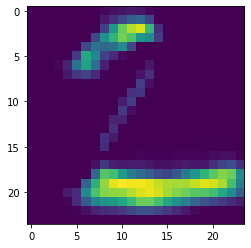

In [178]:
# applying relu and plotting the heat map
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)
print(heatmap.shape)

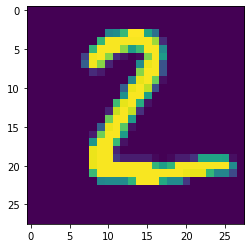

In [179]:
#test image
plt.imshow(x_test_inp[1])